# ランク法による累積分布関数の予測
## 製品寿命データの読み込み
まず累積分布関数を予測するデータを読み込む。jupyter notebookは，Pythonコードをセルと呼ばれる単位で分割して実行できる。

データフレームを取り扱うライブラリpandasをインストールする。

In [3]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



インストールしたpandasをpdとして読み込む。以降はpd.メソッド名でpandasの機能が呼び出せる。(pdは好きな名前でいい)

In [5]:
import pandas as pd

読み込むcsvファイルのパス（場所）を文字列(string型)変数として用意して，pandasのread_csvメソッドを使用して必要データを読み込みを行う。  
pythonの文字列変数は，指定の文字列をダブルコーテーションまたはシングルコーテーション（非推奨）で囲うことで宣言できる。
読み込んだライブラリ名.メソッド名で各種機能が利用できる。

In [15]:
filepath = "./datas/1st_week_product_service_lifes.csv"
df = pd.read_csv(filepath)

読み込んだ表の中身をprint()メソッドで確認する。

In [16]:
print(df)

    sample  productA  productB  productC  productD  productE
0        1         3         3       2.0     123.0       3.0
1        2        10         5       6.0     127.0       6.0
2        3        13         6      13.0     134.0       9.0
3        4        16         7      18.0     139.0      12.0
4        5        19         9      26.0     147.0      15.0
5        6        20        11      35.0     156.0      18.0
6        7        23        13      40.0     161.0      21.0
7        8        25        15      56.0     177.0      24.0
8        9        28        17      80.0     201.0      27.0
9       10        29        20      87.0     208.0      30.0
10      11        30        24       NaN       NaN      33.0
11      12        31        29       NaN       NaN      36.0
12      13        33        36       NaN       NaN       NaN
13      14        37        47       NaN       NaN       NaN
14      15        42        69       NaN       NaN       NaN


jupyterでは変数名単一で入力したセルは表示と同じ挙動になる。

In [17]:
df

,sample,productA,productB,productC,productD,productE
0,1,3,3,2.0,123.0,3.0
1,2,10,5,6.0,127.0,6.0
2,3,13,6,13.0,134.0,9.0
3,4,16,7,18.0,139.0,12.0
4,5,19,9,26.0,147.0,15.0
5,6,20,11,35.0,156.0,18.0
6,7,23,13,40.0,161.0,21.0
7,8,25,15,56.0,177.0,24.0
8,9,28,17,80.0,201.0,27.0
9,10,29,20,87.0,208.0,30.0


列名（column）を指定すれば，該当列のみのデータを取り出せる。  
割愛するが，行や単一要素のみも抽出可能。

In [18]:
df["productA"]

0      3
1     10
2     13
3     16
4     19
5     20
6     23
7     25
8     28
9     29
10    30
11    31
12    33
13    37
14    42
Name: productA, dtype: int64

In [19]:
df.productA

0      3
1     10
2     13
3     16
4     19
5     20
6     23
7     25
8     28
9     29
10    30
11    31
12    33
13    37
14    42
Name: productA, dtype: int64

In [22]:
df.iloc[:,[1]]

,productA
0,3
1,10
2,13
3,16
4,19
5,20
6,23
7,25
8,28
9,29


## ランク法による累積分布の作成
pandasは可読性に優れるが，計算には不向きのため，演算用に配列を変換する。  
テンソル演算に特化したライブラリ，numpyをインストール，インポートする。

In [23]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [25]:
import numpy as np

numpyのarrayメソッドで，pandasのデータからある製品を抜き出し行列に変換

In [40]:
data = np.array(df.iloc[:,[3]])

In [41]:
data

array([[ 2.],
       [ 6.],
       [13.],
       [18.],
       [26.],
       [35.],
       [40.],
       [56.],
       [80.],
       [87.],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])

無意味な次元を削減して１次元配列に

In [44]:
squeeze_data = data.squeeze()

In [45]:
squeeze_data 

array([ 2.,  6., 13., 18., 26., 35., 40., 56., 80., 87., nan, nan, nan,
       nan, nan])

無意味なデータnanの判定  
否定演算子~を頭に使用すると反転した結果が得られる

In [54]:
np.isnan(squeeze_data)

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True])

In [55]:
~np.isnan(squeeze_data)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False])

条件がTrueになる成分のみ取り出し

In [56]:
not_nan_data = squeeze_data[~np.isnan(squeeze_data )]

In [57]:
not_nan_data

array([ 2.,  6., 13., 18., 26., 35., 40., 56., 80., 87.])

lenメソッドで，１次元配列の要素数，２次元配列の行数などが取得できる。

In [58]:
len(not_nan_data)

10

### 平均ランク法データの作成
整理したデータの要素数から，累積分布を計算する。
1. 等差数列を作成できるarangeメソッドで，ランク法のｉに対応する数列を作成する。
1. 作成したiをn+1で割る

In [61]:
i = np.arange(1,len(not_nan_data)+1)
average_rank = i / (len(not_nan_data)+1)

In [63]:
i

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [62]:
average_rank

array([0.09090909, 0.18181818, 0.27272727, 0.36363636, 0.45454545,
       0.54545455, 0.63636364, 0.72727273, 0.81818182, 0.90909091])

### グラフ化
得たデータをグラフとして確認する。グラフ描画用のライブラリmatplotlibをインストール

In [65]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


グラフ描画に使用するのは，matplotlibの中のpyplotのみ。.以降にインポートしたいモジュールを指定すると該当のみインポートできる。指定してpltとして読み込み

In [66]:
import matplotlib.pyplot as plt

グラフとして描画したい数列をそれぞれx,yとして定義，複数行に渡る短い処理は，;で繋げられる。

In [68]:
x = not_nan_data; y = average_rank

グラフを描画する。基本的には，plt.plot(x,y)でグラフデータを与えて，plt.show()メソッドで描画する。
その間に，xlabelなどのパラメータを追加すると，グラフに反映される。

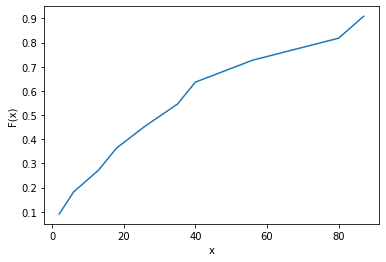

In [71]:
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('F(x)')
plt.show()

## 複数製品をループで処理する
ここまでの処理をループさせる。